In [1]:
from pyspark.sql import SparkSession
import pandas as pd
import pyspark.sql.functions as F
import pyspark.sql.types as T

from pyspark.ml import Pipeline
from pyspark.ml.feature import HashingTF, Tokenizer, StringIndexer, CountVectorizer, IDF, StopWordsRemover
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

from nltk.corpus import stopwords
import re as re

from pyspark.ml.linalg import Vector, Vectors, SparseVector
from pyspark.ml.clustering import LDA, LDAModel

from sparknlp.base import *
from sparknlp.annotator import *
from sparknlp.pretrained import PretrainedPipeline
import sparknlp

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

sns.set_style('whitegrid')

In [2]:
%%capture
spark = sparknlp.start()

In [4]:
df = spark.read.csv("gs://bdp_group6_bckt_2/data/processed_data/processed_data.parquet",
                    inferSchema=True, header=True,
                    multiLine=True, quote='\"', escape='\"')
df.printSchema()

root
 |-- paper_id: string (nullable = true)
 |-- cord_uid: string (nullable = true)
 |-- source_x: string (nullable = true)
 |-- publish_time: string (nullable = true)
 |-- journal: string (nullable = true)
 |-- body_text: string (nullable = false)
 |-- title: string (nullable = true)
 |-- abstract: string (nullable = true)
 |-- authors: string (nullable = true)



In [6]:
df.count()

598169

In [7]:
df.show(5)

+--------------------+--------------------+--------+--------------------+--------------------+-------------------+--------------------+--------------------+
|            paper_id|               title|cord_uid|            source_x|            abstract|       publish_time|             authors|             journal|
+--------------------+--------------------+--------+--------------------+--------------------+-------------------+--------------------+--------------------+
|0000b6da665726420...|The cell phone vi...|a86g6p2d|   Medline; PMC; WHO|Objective: An at ...|2021-09-25 00:00:00|Yang, Alex; Lewis...|Laryngoscope Inve...|
|0000b93c66f991236...|Infections in Hem...|j4qfcalo|                 PMC|Infections in pat...|2021-01-29 00:00:00|George, Biju; Bha...|Contemporary Bone...|
|000122a9a774ec76f...|Impact of COVID-1...|7xtb3rtg|Elsevier; Medline...|Introduction and ...|2020-09-08 00:00:00|Rodríguez-Leor, O...|Rev Esp Cardiol (...|
|00013694fb8095bb8...|Widening the divi...|pnfnfpnh|      

In [25]:
eng_stopwords = stopwords.words('english')
custom_words = ['covid', 'patient', 'sarscov', 'sars-cov', 'clinical', 'care', 'pandemic', 'health',
                'use', 'among', 'impact', 'student', 'study', 'de', 'r', 'la', 'der', 'ed', 'en']
eng_stopwords += custom_words

In [26]:
def create_pipeline(column):
    documentAssembler = DocumentAssembler() \
         .setInputCol(column) \
         .setOutputCol('document')

    tokenizer = Tokenizer() \
         .setInputCols(['document']) \
         .setOutputCol('token')

    normalizer = Normalizer() \
         .setInputCols(['token']) \
         .setOutputCol('normalized') \
         .setLowercase(True)

    stopwords_cleaner = StopWordsCleaner() \
         .setInputCols(['normalized']) \
         .setOutputCol('clean_normalized') \
         .setCaseSensitive(False) \
         .setStopWords(eng_stopwords)

    lemmatizer = LemmatizerModel.pretrained() \
         .setInputCols(['clean_normalized']) \
         .setOutputCol('lemma')
    
    stopwords_cleaner2 = StopWordsCleaner() \
         .setInputCols(['lemma']) \
         .setOutputCol('clean_lemma') \
         .setCaseSensitive(False) \
         .setStopWords(eng_stopwords)

    finisher = Finisher() \
        .setInputCols(["clean_lemma"]) \
        .setOutputCols(["tokens"]) \
        .setOutputAsArray(True) \
        .setCleanAnnotations(False)

    pipeline = Pipeline() \
         .setStages([
               documentAssembler,
               tokenizer,
               normalizer,
               stopwords_cleaner,
               lemmatizer,
               stopwords_cleaner2,
               finisher
         ])
    
    return pipeline

In [27]:
title_pipeline = create_pipeline("title")  # On basis of titles
abstract_pipeline = create_pipeline("abstract")  # On absis of abstract

lemma_antbnc download started this may take some time.
Approximate size to download 907.6 KB
[OK!]


In [27]:
title_model = title_pipeline.fit(df)
title_df  = title_model.transform(df)

title_df.show(5)

+--------------------+--------------------+--------+--------------------+--------------------+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|            paper_id|               title|cord_uid|            source_x|            abstract|       publish_time|             authors|             journal|            document|               token|          normalized|    clean_normalized|               lemma|              tokens|
+--------------------+--------------------+--------+--------------------+--------------------+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|0000b6da665726420...|The cell phone vi...|a86g6p2d|   Medline; PMC; WHO|Objective: An at ...|2021-09-25 00:00:00|Yang, Alex; Lewis...|Laryngoscope Inv

In [28]:
abstract_model = abstract_pipeline.fit(df)
abstract_df  = abstract_model.transform(df)

abstract_df.show(5)

+--------------------+--------------------+--------+--------------------+--------------------+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|            paper_id|               title|cord_uid|            source_x|            abstract|       publish_time|             authors|             journal|            document|               token|          normalized|    clean_normalized|               lemma|         clean_lemma|              tokens|
+--------------------+--------------------+--------+--------------------+--------------------+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|0000b6da665726420...|The cell phone vi...|a86g6p2d|   Medline; PMC; WHO|Objective: An a

In [29]:
cv = CountVectorizer(
    inputCol="tokens",
    outputCol="rawFeatures",
    vocabSize=1000,
    minDF=10
)
idf = IDF(
    inputCol="rawFeatures",
    outputCol="features",
    minDocFreq=5
)

In [30]:
cv_model = cv.fit(abstract_df)
cv_df = cv_model.transform(abstract_df)

idf_model = idf.fit(cv_df)
idf_df = idf_model.transform(cv_df)

In [58]:
num_topics = 5
lda = LDA(k=num_topics, maxIter=10)
model = lda.fit(idf_df)
ll = model.logLikelihood(idf_df)
lp = model.logPerplexity(idf_df)
print("The lower bound on the log likelihood of the entire corpus:", ll)
print("The upper bound on perplexity:", lp)

The lower bound on the log likelihood of the entire corpus: -788544774.2573736
The upper bound on perplexity: 6.56052930338536


In [59]:
# extract vocabulary from CountVectorizer
vocab = cv_model.vocabulary
topics = model.describeTopics()   
topics_rdd = topics.rdd
topics_words = topics_rdd\
       .map(lambda row: row['termIndices'])\
       .map(lambda idx_list: [vocab[idx] for idx in idx_list])\
       .collect()
for idx, topic in enumerate(topics_words):
    print("topic: {}".format(idx + 1))
    print("*"*25)
    for word in topic:
        print(word)
    print("*"*25)

topic: 1
*************************
cell
antibody
la
vaccine
food
immune
response
mask
virus
expression
*************************
topic: 2
*************************
social
mental
research
service
stress
anxiety
experience
support
behavior
work
*************************
topic: 3
*************************
patient
p
ci
day
group
hospital
case
mortality
outcome
symptom
*************************
topic: 4
*************************
student
vaccination
nurse
vaccine
patient
risk
dose
p
disease
infection
*************************
topic: 5
*************************
virus
model
viral
protein
rna
sequence
human
infection
detection
drug
*************************


In [31]:
# For wordcloud on TF-IDF
corpus_dict = {cv_model.vocabulary[i]: idf_model.idf[i] for i in range(len(idf_model.idf))}
len(corpus_dict)

1000

In [34]:
# For wordcloud on CV
total_counts = cv_df[["rawFeatures"]].rdd \
        .map(lambda row: row["rawFeatures"].toArray()) \
        .reduce(lambda x,y: [x[i] + y[i] for i in range(len(y))])

vocab_dict = dict(zip(cv_model.vocabulary, total_counts))
len(vocab_dict)

1000

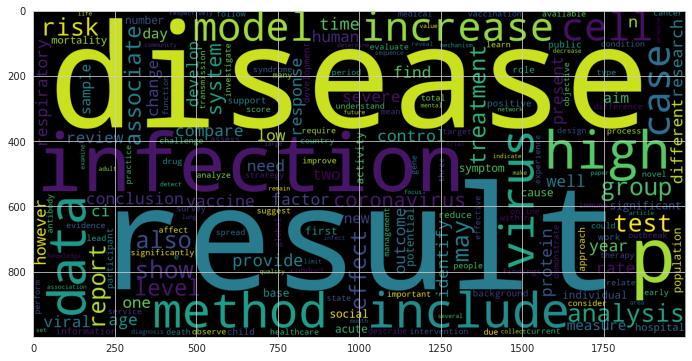

In [35]:
# CV wordloud
plt.figure(figsize=(15, 6))
wordcloud = WordCloud(width=2000, height=1000).generate_from_frequencies(vocab_dict)
plt.imshow(wordcloud)
plt.show()

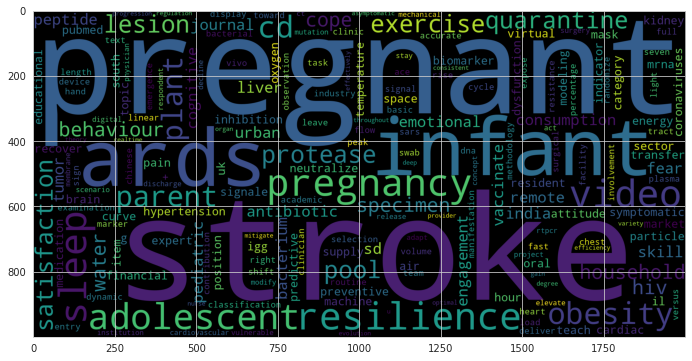

In [32]:
# TF-IDF wordcloud
plt.figure(figsize=(15, 6))
wordcloud = WordCloud(width=2000, height=1000).generate_from_frequencies(corpus_dict)
plt.imshow(wordcloud)
plt.show()